In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [527]:
#defining triangular lattice
a=1
a_1=a*np.array([1,0,0])
a_2=a*np.array([1/2,np.sqrt(3)/2,0])
zhat=np.array([0,0,1])

Vol_real=np.dot(np.cross(a_1,a_2),zhat)
b_1=np.cross(a_2,zhat)*(2*np.pi)/Vol_real
b_2=np.cross(zhat,a_1)*(2*np.pi)/Vol_real
Vol_rec=np.dot(np.cross(b_1,b_2),zhat)
#print(np.dot(a_2,b_2),np.dot(a_1,b_1))

Np=80
n1=np.arange(-Np,Np+1)
n2=np.arange(-Np,Np+1)

a_1=a_1[0:2]
a_2=a_2[0:2]
b_1=b_1[0:2]
b_2=b_2[0:2]

In [528]:
#defining the parameter gamma in the static structure factor
def gamma(kx,ky):
    
    a_1=a*np.array([1,0])
    a_2=a*np.array([1/2,np.sqrt(3)/2])
    
    #creating lattice
    Np=4
    n1=np.arange(-Np,Np+1)
    n2=np.arange(-Np,Np+1)
    Recip_lat=[]
    for i in n1:
        for j in n2:
            point=a_1*i+a_2*j
            Recip_lat.append(point)
    
    #getting the nearest neighbours to the gamma point
    Recip_lat_arr=np.array(Recip_lat)
    dist=np.round(np.sqrt(np.sum(Recip_lat_arr**2, axis=1)),decimals=8)
    sorted_dist=sort(list(set(dist)) )
    nns=Recip_lat_arr[np.where( (dist<sorted_dist[2]) *( dist>0 ))[0]]
    e=0
    for nn in nns:
        e=e+exp(1j*(nn[0]*kx+nn[1]*ky))
    
    return np.real(e)



In [529]:

kx=np.linspace(-2*np.pi/a,2*np.pi/a,100)
ky=np.linspace(-2*np.pi/a,2*np.pi/a,100)

kxx, kyy =meshgrid(kx,ky)

def Sf(kx,ky,lam,T):
    return 1/(lam+(1/T)*gamma(kx,ky))

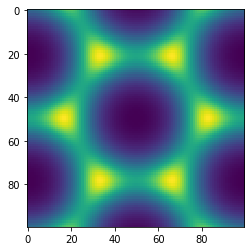

In [530]:
imshow(Sf(kxx,kyy,0.5,10))

In [531]:
#getting the first brilloin zone from the Voronoi decomp of the recipprocal lattice
#input: reciprocal lattice vectors
#output: Points that delimit the FBZ - 
#high symmetry points (for now just the triangular lattice will be implemented)
from scipy.spatial import Voronoi, voronoi_plot_2d
def FBZ_points(b_1,b_2):
    #creating reciprocal lattice
    Np=4
    n1=np.arange(-Np,Np+1)
    n2=np.arange(-Np,Np+1)
    Recip_lat=[]
    for i in n1:
        for j in n2:
            point=b_1*i+b_2*j
            Recip_lat.append(point)
    
    #getting the nearest neighbours to the gamma point
    Recip_lat_arr=np.array(Recip_lat)
    dist=np.round(np.sqrt(np.sum(Recip_lat_arr**2, axis=1)),decimals=10)
    sorted_dist=sort(list(set(dist)) )
    points=Recip_lat_arr[np.where(dist<sorted_dist[2])[0]]
    
    #getting the voronoi decomposition of the gamma point and the nearest neighbours
    vor = Voronoi(points)
    Vertices=(vor.vertices)
    
    #ordering the points counterclockwise in the -pi,pi range
    angles_list=list(np.arctan2(Vertices[:,1],Vertices[:,0]))
    Vertices_list=list(Vertices)
    
    #joint sorting the two lists for angles and vertices for convenience later. 
    # the linear plot routine requires the points to be in order
    # atan2 takes into acount quadrant to get the sign of the angle 
    angles_list, Vertices_list = (list(t) for t in zip(*sorted(zip(angles_list, Vertices_list))))
    
    ##getting the M points as the average of consecutive K- Kp points
    Edges_list=[]
    for i in range(len(Vertices_list)):
        Edges_list.append([(Vertices_list[i][0]+Vertices_list[i-1][0])/2,(Vertices_list[i][1]+Vertices_list[i-1][1])/2])
    
    Gamma=[0,0]
    K=Vertices_list[0::2]
    Kp=Vertices_list[1::2]
    M=Edges_list[0::2]
    Mp=Edges_list[1::2]
    
    return Vertices_list, Gamma, K, Kp, M, Mp

In [532]:
Vertices_list, Gamma, K, Kp, M, Mp=FBZ_points(b_1,b_2)

In [533]:
#creating reciprocal lattice preparing for k-point integration
Recip_lat=[]
for i in n1:
    for j in n2:
        point=b_1*i+b_2*j
        Recip_lat.append(point)


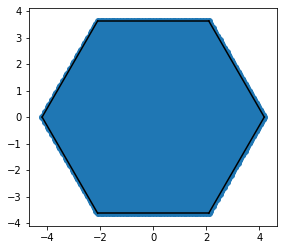

In [534]:

t=np.linspace(0,1,1000)
pol=np.array(Vertices_list).T
for i in range(6):
    plt.plot(pol[0,i%6]*(1-t)+t*pol[0,(i+1)%6],pol[1,i%6]*(1-t)+t*pol[1,(i+1)%6],c='k')

#generating k points
kx=np.linspace(-5*np.pi/a,5*np.pi/a,100)
ky=np.linspace(-5*np.pi/a,5*np.pi/a,100)

#square sampling
#kxx,kyy=np.meshgrid(kx,ky)

#Shrinking the reciprocal lattice
scale_fac=0.00831
Recip_lat_arr=scale_fac*np.array(Recip_lat)
kxx=Recip_lat_arr[:,0]
kyy=Recip_lat_arr[:,1]

phi=2*np.pi/6 #rotation angle 

#rotating and cleaving if absolute value of rotated point's y coordinate exceeds top boundary of 1BZ
kxx_rot=np.cos(phi)*kxx-np.sin(phi)*kyy
kyy_rot=np.sin(phi)*kxx+np.cos(phi)*kyy

kxx2=kxx[np.where(np.abs(kyy_rot)<K[2][1])]
kyy2=kyy[np.where(np.abs(kyy_rot)<K[2][1])]

#rotating and cleaving if absolute value of rotated point's y coordinate exceeds top boundary of 1BZ
kxx_rot2=np.cos(-phi)*kxx2-np.sin(-phi)*kyy2
kyy_rot2=np.sin(-phi)*kxx2+np.cos(-phi)*kyy2

kxx3=kxx2[np.where(np.abs(kyy_rot2)<K[2][1])]
kyy3=kyy2[np.where(np.abs(kyy_rot2)<K[2][1])]

#cleaving if absolute value of point's y coordinate exceeds top boundary of 1BZ
KX=kxx3[np.where(np.abs(kyy3)<K[2][1])]
KY=kyy3[np.where(np.abs(kyy3)<K[2][1])]

#np.where(np.abs(kyy)<K_point_3[1] and 
#scatter(kxx_rot,kyy_rot)
#scatter(kxx,kyy)
scatter(KX,KY)
plt.gca().set_aspect('equal', adjustable='box')

14521 14400


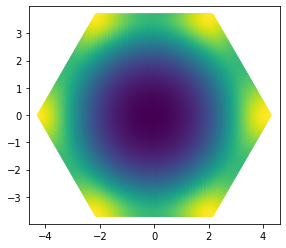

In [536]:
print((np.size(KX)),120 * 120) #number of points in the bz
#structure factor for random values of temperature and lambda
scatter(KX,KY,c=Sf(KX,KY,3,2))
plt.gca().set_aspect('equal', adjustable='box')

In [539]:
Nlam=2000
T=1
curlyN=np.size(KX)
lambds=np.linspace(3/T,20 ,Nlam)
integs=[]
for i in range(Nlam):
    integral=3*np.sum(Sf(KX,KY,lambds[i],T))/curlyN
    integs.append(integral)

4.182091045522761 1.000872214334099


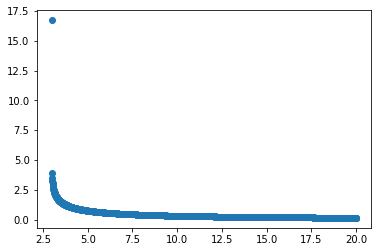

In [540]:
scatter(lambds,integs)
ind_sol=np.argmin(np.abs(np.array(integs)-1))
print(lambds[ind_sol],integs[ind_sol])

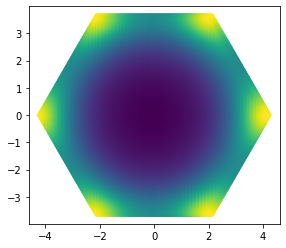

In [541]:
#After the solution
scatter(KX,KY,c=Sf(KX,KY,lambds[ind_sol],T))
plt.gca().set_aspect('equal', adjustable='box')

# reproducing solution of large N self-consistent equation

In [560]:
Ts=np.linspace(0.5,10,40)
lambdsol=[]
intsol=[]
for Ti in Ts:
    lambds=np.linspace(3/Ti,20 ,Nlam)
    integs=[]
    for i in range(Nlam):
        integral=3*np.sum(Sf(KX,KY,lambds[i],Ti))/curlyN
        integs.append(integral)
    ind_sol=np.argmin(np.abs(np.array(integs)-1))
    lambdsol.append(lambds[ind_sol])
    intsol.append(integs[ind_sol])

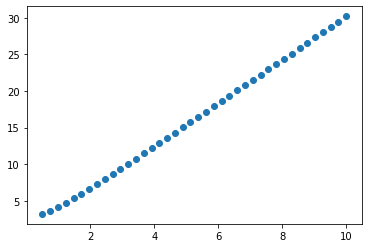

In [561]:
scatter(Ts,np.array(lambdsol)*Ts)

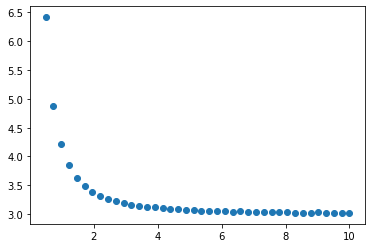

In [562]:
scatter(Ts,np.array(lambdsol))

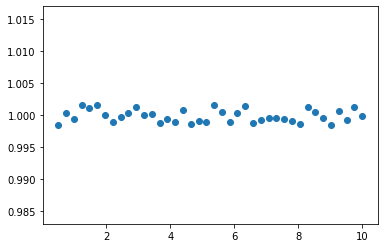

In [563]:
scatter(Ts,np.array(intsol))

# Now getting the dynamic result

In [564]:
Nlam=3000
T=10
curlyN=np.size(KX)
lambds=np.linspace(3/T,20 ,Nlam)
integs=[]
for i in range(Nlam):
    integral=3*np.sum(Sf(KX,KY,lambds[i],T))/curlyN
    integs.append(integral)

3.019506502167389 0.9999703065561594


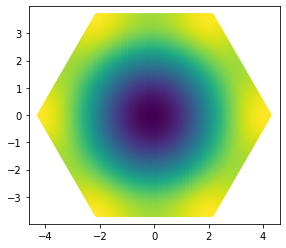

In [565]:
ind_sol=np.argmin(np.abs(np.array(integs)-1))
print(lambds[ind_sol],integs[ind_sol])
lamb_s=lambds[ind_sol]
#After the solution
scatter(KX,KY,c=Sf(KX,KY,lambds[ind_sol],T))
plt.gca().set_aspect('equal', adjustable='box')

In [566]:
#dynamic structure fac
def Sfw(kx,ky,lam,T,ome, alph):
    fq=(gamma(kx,ky)**2)/T +gamma(kx,ky)*(lam-6/T)- 6*lam
    fq=alph*fq
    return -2*Sf(kx,ky,lam,T)*(fq/(ome**2+fq**2))

In [567]:
alph=0.00088969

In [568]:
#linear parametrization accross different points in the BZ
def linpam(Kps,Npoints_q):
    Npoints=len(Kps)
    t=np.linspace(0, 1, Npoints_q)
    linparam=np.zeros([Npoints_q*(Npoints-1),2])
    print(np.shape(linparam))
    for i in range(Npoints-1):
        linparam[i*Npoints_q:(i+1)*Npoints_q,0]=Kps[i][0]*(1-t)+t*Kps[i+1][0]
        linparam[i*Npoints_q:(i+1)*Npoints_q,1]=Kps[i][1]*(1-t)+t*Kps[i+1][1]
        
    return linparam

(60, 2)
(60, 2)
(3000, 2)


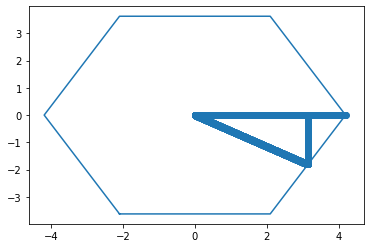

In [569]:
VV=Vertices_list+[Vertices_list[0]]
plot(linpam(VV,10)[:,0],linpam(VV,10)[:,1])
L=[]
L=L+[K[1]]+[Gamma]+[M[1]]+[[np.pi,0]]
Nt=1000
kpath=linpam(L,Nt)
scatter(kpath[:,0],kpath[:,1])

In [570]:
Nomegs=2000
omegas=np.linspace(0.0001,0.1,Nomegs)
t=np.arange(0,len(kpath),1)
t_m,omegas_m=meshgrid(t,omegas)
SSSfw=Sfw(kpath[t_m,0],kpath[t_m,1],lamb_s,T,omegas_m, alph)

Text(0, 0.5, '$\\omega$')

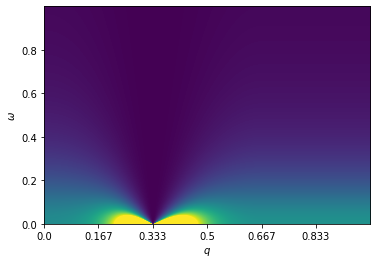

In [571]:
imshow(SSSfw, vmax=70 ,origin='lower')
Npl=np.arange(0,Nomegs,int(Nomegs/5))
Npl2=np.arange(0,len(kpath),int(len(kpath)/6))
om=np.round(np.linspace(0,1,6),3)
t=np.round(np.linspace(0,1,7),3)
plt.xticks(Npl2,t)
plt.yticks(Npl,om)
plt.xlabel(r"$q$")
plt.ylabel(r"$\omega$")

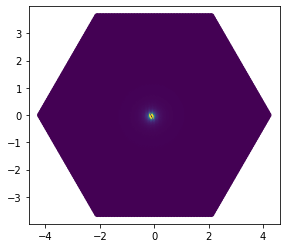

In [572]:
scatter(KX,KY,c=Sfw(KX,KY,lamb_s,T,0.00001, alph))
plt.gca().set_aspect('equal', adjustable='box')

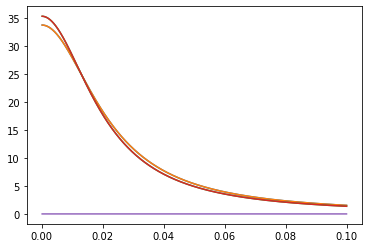

In [573]:
SSSfw_K=Sfw(K[0][0],K[0][1],lamb_s,T,omegas, alph)
plot(omegas,SSSfw_K)
SSSfw_K=Sfw(Kp[0][0],Kp[0][1],lamb_s,T,omegas, alph)
plot(omegas,SSSfw_K)
SSSfw_K=Sfw(M[0][0],M[0][1],lamb_s,T,omegas, alph)
plot(omegas,SSSfw_K)
SSSfw_K=Sfw(Mp[0][0],Mp[0][1],lamb_s,T,omegas, alph)
plot(omegas,SSSfw_K)
SSSfw_K=Sfw(Gamma[0],Gamma[1],lamb_s,T,omegas, alph)
plot(omegas,SSSfw_K)

# Test data for running integration routine

In [574]:
#dynamic structure fac
def Sfw_diff(kx,ky,lam,T,ome, alph):
    q=np.sqrt(kx**2 +ky**2)
    #D=0.85
    #C=4.0
    C=1
    D=0.31
    return Sfw(kx,ky,lam,T,ome, alph)+C*(D/((ome/q**2)**2+D**2))/q**2

In [575]:
Nlam=3000
T=10
curlyN=np.size(KX)
lambds=np.linspace(3/T,20 ,Nlam)
integs=[]
for i in range(Nlam):
    integral=3*np.sum(Sf(KX,KY,lambds[i],T))/curlyN
    integs.append(integral)
    
ind_sol=np.argmin(np.abs(np.array(integs)-1))
print(lambds[ind_sol],integs[ind_sol])
lamb_s=lambds[ind_sol]
alph=0.00088969

3.019506502167389 0.9999703065561594


(60, 2)
(60, 2)
(3000, 2)


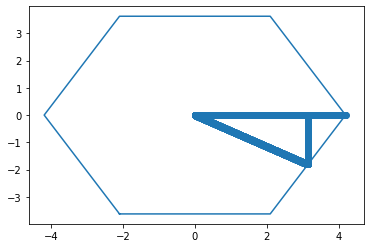

In [576]:
VV=Vertices_list+[Vertices_list[0]]
plot(linpam(VV,10)[:,0],linpam(VV,10)[:,1])
L=[]
L=L+[K[1]]+[Gamma]+[M[1]]+[[np.pi,0]]
Nt=1000
kpath=linpam(L,Nt)
scatter(kpath[:,0],kpath[:,1])

In [577]:
Nomegs=2000
#omegas=np.linspace(0.000001,0.1,Nomegs)
omegas=np.logspace(-5,1,Nomegs)
t=np.arange(0,len(kpath),1)
t_m,omegas_m=meshgrid(t,omegas)
SSSfw=Sfw_diff(kpath[t_m,0],kpath[t_m,1],lamb_s,T,omegas_m, alph)

/Users/jfmv/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in true_divide
  
/Users/jfmv/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


Text(0, 0.5, '$\\omega$')

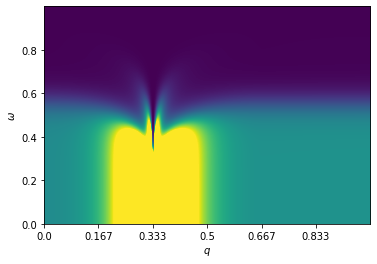

In [578]:
imshow(SSSfw, vmax=70 ,origin='lower')
Npl=np.arange(0,Nomegs,int(Nomegs/5))
Npl2=np.arange(0,len(kpath),int(len(kpath)/6))
om=np.round(np.linspace(0,1,6),3)
t=np.round(np.linspace(0,1,7),3)
plt.xticks(Npl2,t)
plt.yticks(Npl,om)
plt.xlabel(r"$q$")
plt.ylabel(r"$\omega$")

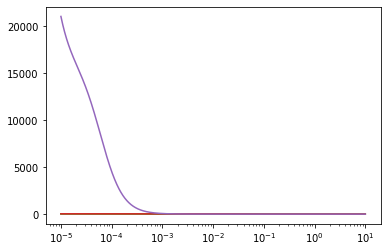

In [579]:
SSSfw_K=Sfw_diff(K[0][0],K[0][1],lamb_s,T,omegas, alph)
plot(omegas,SSSfw_K)
SSSfw_K=Sfw_diff(Kp[0][0],Kp[0][1],lamb_s,T,omegas, alph)
plot(omegas,SSSfw_K)
SSSfw_K=Sfw_diff(M[0][0],M[0][1],lamb_s,T,omegas, alph)
plot(omegas,SSSfw_K)
SSSfw_K=Sfw_diff(Mp[0][0],Mp[0][1],lamb_s,T,omegas, alph)
plot(omegas,SSSfw_K)
SSSfw_K=Sfw_diff(Gamma[0]-0.01,Gamma[1]-0.01,lamb_s,T,omegas, alph)
plot(omegas,SSSfw_K)
xscale('log')

0.5
(60, 2)
(60, 2)
(3000, 2)


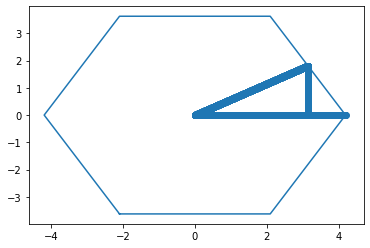

Text(0, 0.5, '$\\omega$')

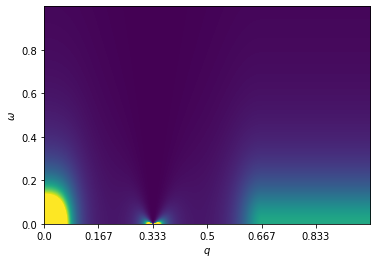

In [758]:
ind=0
print(Ts[ind])

VV=Vertices_list+[Vertices_list[0]]
plot(linpam(VV,10)[:,0],linpam(VV,10)[:,1])
L=[]
L=L+[K[1]]+[Gamma]+[Mp[1]]+[[np.pi,0]]
Nt=1000
kpath=linpam(L,Nt)
scatter(kpath[:,0],kpath[:,1])
plt.show()


Nomegs=2000
omegas=np.linspace(0.000001,0.1,Nomegs)
#omegas=np.logspace(-5,1,Nomegs)
t=np.arange(0,len(kpath),1)
t_m,omegas_m=meshgrid(t,omegas)
SSSfw=Sfw(kpath[t_m,0],kpath[t_m,1],lambdsol[ind],Ts[ind],omegas_m, alph)

imshow(SSSfw, vmax=80 ,origin='lower')
Npl=np.arange(0,Nomegs,int(Nomegs/5))
Npl2=np.arange(0,len(kpath),int(len(kpath)/6))
om=np.round(np.linspace(0,1,6),3)
t=np.round(np.linspace(0,1,7),3)
plt.xticks(Npl2,t)
plt.yticks(Npl,om)
plt.xlabel(r"$q$")
plt.ylabel(r"$\omega$")

# example nasty integration

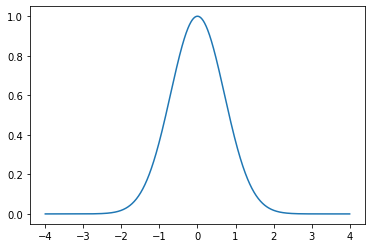

In [759]:
NP=1000
x = linspace(-4.0,4.0,NP)
f = exp(-(x**2))
plot(x,f)

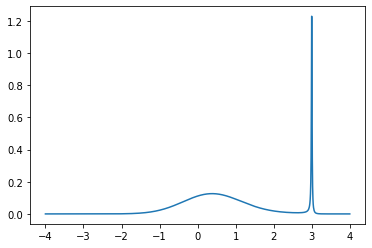

In [760]:
def nasty_function(x):
    x_0 = 3.0
    a = 0.01
    return exp(-(x**2))/((x-x_0)**2 + a**2)

f = nasty_function(x)
plot(x,f)

In [761]:
x_walk = empty((0)) #this is an empty list to keep all the steps
x_0 = 8.0*((random.random())-0.5) #this is the initialization
x_walk = append(x_walk,x_0)
print(x_walk)

[-0.31219855]


In [762]:
n_iterations = 200000 #this is the number of iterations I want to make

fs=[]

for i in range(n_iterations):
    x_prime = np.random.normal(x_walk[i], 0.1) #0.1 is the sigma in the normal distribution
    alpha = nasty_function(x_prime)/nasty_function(x_walk[i])
    fs.append(nasty_function(x_prime))
    if(alpha>=1.0):
        x_walk  = append(x_walk,x_prime)
    else:
        beta = random.random()
        if(beta<=alpha):
            x_walk = append(x_walk,x_prime)
        else:
            x_walk = append(x_walk,x_walk[i])


0.28554027927447645


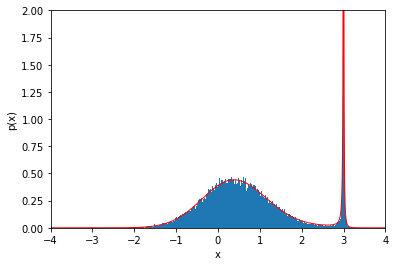

In [763]:
f = nasty_function(x)
norm = trapz(f*(x[1]-x[0]))
plot(x,f/norm, linewidth=1, color='r')
count, bins, ignored = plt.hist(x_walk, NP, density=True)

#fig = figure(1, figsize=(9.5,6.5))
plt.xlabel('x')
plt.ylabel('p(x)')

plt.xlim([-4.0,4.0])
plt.ylim([0.0,2.0])
print(norm)
#0.2855402797342184
#0.28554027927447645

0.4382844428894263


(-4.0, 4.0)

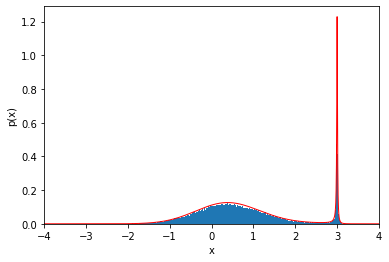

In [764]:
f = nasty_function(x)
norm = 1
plot(x,f/norm, linewidth=1, color='r')
count, bins = np.histogram(x_walk, bins=NP, density=True)

print(count[int(NP/2)])

plt.bar(bins[:-1],f[int(NP/2)]*count/count[int(NP/2)],bins[1]-bins[0])
#fig = figure(1, figsize=(9.5,6.5))
plt.xlabel('x')
plt.ylabel('p(x)')

plt.xlim([-4.0,4.0])
#plt.ylim([0.0,2.0])


In [765]:
print(np.mean(np.array(fs))*4)


0.37725556957124606


# dispersion

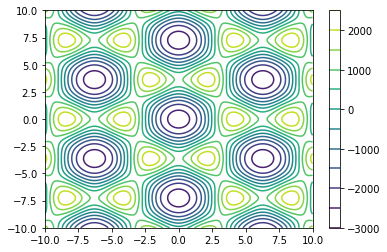

In [1109]:
tp1=568
tp2=-108 #/tpp1
#defining tight bindind dispersion

a_1=a*np.array([1,0])
a_2=a*np.array([1/2,np.sqrt(3)/2])
    
#creating lattice
Np=4
n1=np.arange(-Np,Np+1)
n2=np.arange(-Np,Np+1)
Recip_lat=[]
for i in n1:
    for j in n2:
        point=a_1*i+a_2*j
        Recip_lat.append(point)
    
#getting the nearest neighbours to the gamma point
Recip_lat_arr=np.array(Recip_lat)
dist=np.round(np.sqrt(np.sum(Recip_lat_arr**2, axis=1)),decimals=8)
sorted_dist=sort(list(set(dist)) )
nns=Recip_lat_arr[np.where( (dist<sorted_dist[2]) *( dist>0 ))[0]]
nnns=Recip_lat_arr[np.where( (dist<sorted_dist[3]) *( dist>sorted_dist[1] ))[0]]
def e2d(kx,ky, mu):
    e=0
    for nn in nns:
        e=e-tp1*exp(1j*(nn[0]*kx+nn[1]*ky))
    for nnn in nnns:
        e=e-tp2*exp(1j*(nnn[0]*kx+nnn[1]*ky))
    return np.real(e)-mu

 
#plotting contours
x = np.linspace(-10, 10, 300)
X, Y = np.meshgrid(x, x)
Z = e2d(X, Y, 0)
plt.contour(X, Y, Z,10);
colorbar()

# Parts of the integrand

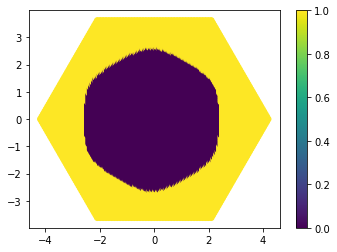

In [824]:
kb=861.7333
J=5.11

T=0.5*J/kb
def nf(e, T):
    
    return 1/(np.exp(e/T)+1)
-e2d(kx, ky, 0)

scatter(KX,KY,c=nf(-e2d(KX,KY, 0), T))
colorbar()
plt.gca().set_aspect('equal', adjustable='box')


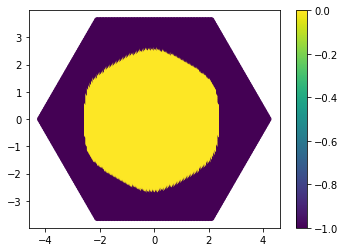

In [853]:
def nb(e, T):
    
    return 1/(np.exp(e/T)-1)


scatter(KX,KY,c=nb(-e2d(KX,KY, 0), T))
colorbar()
plt.gca().set_aspect('equal', adjustable='box')


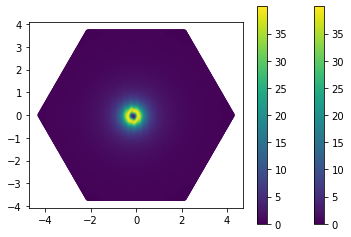

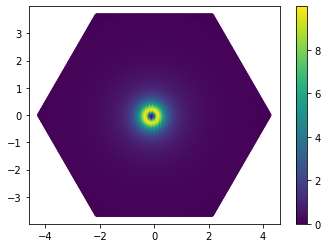

In [1166]:
def dp(kx,ky, w):
    D=0.85
    C=4.0
    #C=1
    #D=0.31
    eps=1e-17
    q=np.sqrt(kx**2 +ky**2)
    
    return C*(D/((w/(q+eps*1j)**2)**2+D**2+eps*1j))/(q+eps*1j)**2
    #return C*(D*(w/(q**2))/((w/q)**2+(D*q)**2+eps*1j))

scatter(KX,KY,c=dp(KX,KY, 0.05))
colorbar()
plt.gca().set_aspect('equal', adjustable='box')


def dp2(kx,ky, w):
    D=0.85
    C=4.0
    #C=1
    #D=0.31
    eps=1e-17
    q=np.sqrt(kx**2 +ky**2)
    
    #return C*(D/((w/(q+eps*1j)**2)**2+D**2+eps*1j))/(q+eps*1j)**2
    return D*(q**2)/(w**2+(D*(q**2))**2)

scatter(KX,KY,c=dp(KX,KY, 0.05))
colorbar()
plt.gca().set_aspect('equal', adjustable='box')
show()

scatter(KX,KY,c=dp2(KX,KY, 0.05))
colorbar()
plt.gca().set_aspect('equal', adjustable='box')

In [1152]:
def integrand(qx,qy,kx,ky,w,T,alph,lam):
    eps=1e-7
    J=2*5.17
    om=w-e2d(kx+qx, ky+qy, 0)
    om2=-e2d(kx+qx, ky+qy, 0)
    nb_we=1/(np.exp(om/T)-1)
    nf_e=1/(np.exp(om2/T)+1)
    q=np.sqrt(qx**2 +qy**2)+eps*1j
    
    D=0.85
    C=4.0
    #C=1
    #D=0.31
    fq=(gamma(qx,qy)**2)*J/T +gamma(qx,qy)*(lam-6*J/T)- 6*lam
    fq=alph*J*fq  #alpha has units of 1/s , multiplying by 
    
    SF=1/(lam+(J/T)*gamma(qx,qy)+eps*1j)
    SD= fq/(om**2+fq**2+eps*1j)
    SS= SD+C*J*D/((om/q)**2+(D*q)**2)
    
    #SD= -2*SF*fq/(om**2+fq**2+eps*1j)
    #SS= SD+C*D/((om/q)**2+(D*q)**2)
    
    #return np.real(2*np.pi*SS*(nb_we+nf_e)/(1+nb_we+eps*1j))
    return np.real(SD)
    

In [1153]:
Ts_p=Ts*J
print(Ts_p)

[ 2.555       3.79974359  5.04448718  6.28923077  7.53397436  8.77871795
 10.02346154 11.26820513 12.51294872 13.75769231 15.0024359  16.24717949
 17.49192308 18.73666667 19.98141026 21.22615385 22.47089744 23.71564103
 24.96038462 26.20512821 27.44987179 28.69461538 29.93935897 31.18410256
 32.42884615 33.67358974 34.91833333 36.16307692 37.40782051 38.6525641
 39.89730769 41.14205128 42.38679487 43.63153846 44.87628205 46.12102564
 47.36576923 48.61051282 49.85525641 51.1       ]


In [1154]:
integrand(KX,KY,KX[ind2],KY[ind2],0.1,Ts_p[ind],alph,lambdsol[ind])

array([1.86255601e-07, 1.71896225e-07, 1.82522923e-07, ...,
       1.72519786e-07, 2.14162132e-07, 1.43055794e-07])

In [1155]:
ind=1
T=Ts[ind]
lambi=lambdsol[ind]
print(T,lambi)

0.7435897435897436 4.8810784702696175


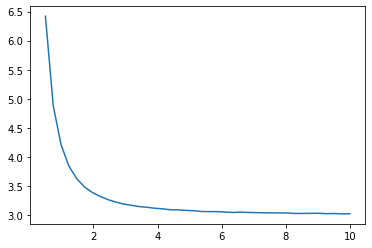

In [1156]:
plot(Ts, lambdsol)

0.9871794871794872


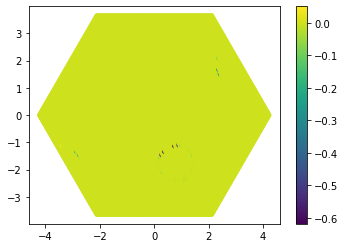

In [1157]:
ind=2
print(Ts[ind])
ind2=10000
scatter(KX,KY,c=integrand(KX,KY,KX[ind2],KY[ind2],2000,Ts_p[ind],alph,lambdsol[ind]) )
plt.gca().set_aspect('equal', adjustable='box')
colorbar()

(60, 2)
(60, 2)


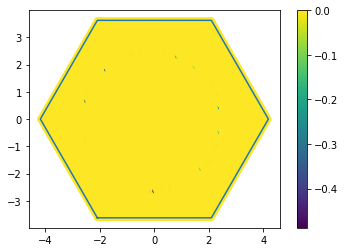

In [1158]:
ind=2
ind2=10000
scatter(KX,KY,c=integrand(KX,KY,0.01,0.01,.9,Ts_p[ind],alph,lambdsol[ind]) )
plt.gca().set_aspect('equal', adjustable='box')
VV=Vertices_list+[Vertices_list[0]]
plot(linpam(VV,10)[:,0],linpam(VV,10)[:,1])
colorbar()

In [1159]:
def Sigm(kx,ky,omega,ind):
    return np.sum(np.sum( integrand(KX,KY,kx,ky,omega,Ts_p[ind],alph,lambdsol[ind]) ))*Vol_rec*scale_fac*scale_fac

In [1160]:
Sigm(1,1,.5,1)

0.02700674599700958

(60, 2)
(60, 2)
(60, 2)


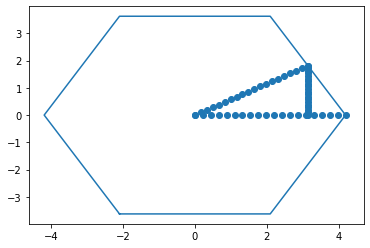

0 / 60
1 / 60
2 / 60
3 / 60
4 / 60
5 / 60
6 / 60
7 / 60
8 / 60
9 / 60
10 / 60
11 / 60
12 / 60
13 / 60
14 / 60
15 / 60
16 / 60
17 / 60
18 / 60
19 / 60
20 / 60
21 / 60
22 / 60
23 / 60
24 / 60
25 / 60
26 / 60
27 / 60
28 / 60
29 / 60
30 / 60
31 / 60
32 / 60
33 / 60
34 / 60
35 / 60
36 / 60
37 / 60
38 / 60
39 / 60
40 / 60
41 / 60
42 / 60
43 / 60
44 / 60
45 / 60
46 / 60
47 / 60
48 / 60
49 / 60
50 / 60
51 / 60
52 / 60
53 / 60
54 / 60
55 / 60
56 / 60
57 / 60
58 / 60
59 / 60


In [1161]:
VV=Vertices_list+[Vertices_list[0]]
plot(linpam(VV,10)[:,0],linpam(VV,10)[:,1])
L=[]
L=L+[K[1]]+[Gamma]+[Mp[1]]+[[np.pi,0]]
Nt=20
kpath=linpam(L,Nt)
scatter(kpath[:,0],kpath[:,1])
plt.show()

Nomegs=20
omegas=np.linspace(2500,6000,Nomegs)
#omegas=np.logspace(-5,1,Nomegs)
t=np.arange(0,len(kpath),1)
t_m,omegas_m=meshgrid(t,omegas)
SSSfw=[]
for t_m_i in t:
    sd=[]
    print(t_m_i,"/",np.size(t))
    for omegas_m_i in omegas:
        sd.append(Sigm(kpath[t_m_i,0],kpath[t_m_i,1],omegas_m_i, 0))
        #print(omegas_m_i,t_m_i)
    SSSfw.append(sd)


Text(0, 0.5, '$\\omega$')

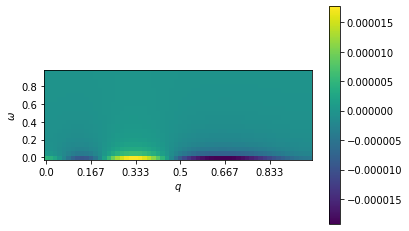

In [1162]:
imshow(np.array(SSSfw).T,origin='lower')
Npl=np.arange(0,Nomegs,int(Nomegs/5))
Npl2=np.arange(0,len(kpath),int(len(kpath)/6))
om=np.round(np.linspace(0,1,6),3)
t=np.round(np.linspace(0,1,7),3)
plt.xticks(Npl2,t)
plt.yticks(Npl,om)
colorbar()
plt.xlabel(r"$q$")
plt.ylabel(r"$\omega$")

In [1135]:
np.max(np.array(SSSfw))

-2.314053956476241e-07

In [1136]:
np.min(np.array(SSSfw))

-0.28676465624589886